In [1]:
import itertools
import warnings
import time

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.special

# The MCMC Hammer
import emcee

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("./data/gardner_hw6/gardner_mt_catastrophe_only_tubulin.csv", comment="#")

In [3]:
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35,25,50,60
1,40.000,45,40,60,75
2,40.000,50,40,60,75
3,45.429,50,45,75,85
4,50.000,55,50,75,115


In [4]:
def log_likelihood(tau, t, m):
    """
    Takes in tau (should be an array), 
    data (Pandas data series), various values for m. 
    We are very proud of this function.
    """
    # sort all values in tau from smallest to greatest
    tau = np.sort(tau)
    
    # set up array to store the log likelihoods calculated for each
    # value of t
    log_like = np.empty(len(t))
    
    # iterate over all values of t (i.e. your data series)
    for i in range(len(t)):
        
        num_handler = np.empty( m) # the numerator of the scaling factor
        exp_handler = np.empty(m) # the exponent part of the numerators
        den_handler = np.empty(m) # denominator of the scaling factor
        den_elements = [] # elements we need to take the product of to get denominator
                          # of the scaling factor
        func_handler = np.empty(m) # the likelihood for a single value of t

        # define the mathematical function for likelihood for a single 
        # value of t
        for j in range(m):
            num_handler[j] = tau[j]**(m-2)
            exp_handler[j] = -t[i]/tau[j]
            for k in range(m):
                if k != j:
                    den_elements.append(tau[j] - tau[k])

            den_handler[j] = np.prod(den_elements)
            den_elements = []

        scaling_factor = num_handler / den_handler
        func_handler = scaling_factor * np.exp(exp_handler)   
        
        # store the log likelihoods in an array 
        log_like[i] = scipy.misc.logsumexp(exp_handler, b=scaling_factor)            
        
        # return the sum of the log likelihoods
    return np.sum(log_like)

def log_prior(tau, m):
    """
    Log prior for model defined above. Takes in m and tau, 
    returns log prior.
    """
    if not np.all(tau > 0):
        return -np.inf
    
    return -np.log(np.prod(tau))
        
def tau_start(m, n_walkers, n_temps):
    p = np.empty((n_temps, n_walkers, m))
    
    for i in range(m):
        p[:,:,i] = np.random.exponential(300, (n_temps,n_walkers))
    return p

In [9]:
def sample_ptmcmc(data, m, model, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    
    # arguments for likelihood
    loglargs = (data, m)
    
    # arguments for prior
    logpargs = (m,)
    
    # starting points for the parameters
    p0 = tau_start(m, n_walkers, n_temps)
    
    # column headings for outputted DataFrames
    columns = {'m = 1': ['tau_1'],
               'm = 2': ['tau_1', 'tau_2'],
               'm = 3': ['tau_1', 'tau_2', 'tau_3']}
    
    return bebi103.run_pt_emcee(
            log_likelihood, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
            threads=threads, columns=columns[model], return_lnZ=True)

In [10]:
#n_burn = 500
#n_steps = 5000
#n_temps = 20
#n_walkers = 50
#m = 3
#p0=tau_start(m, n_walkers, n_temps)
#loglargs = (df["12 uM"], m)
#logpargs = (m,)
#columns = ["tau_1", "tau_2", "tau_3"]

In [ ]:
# Sample three models using PTMCMC; this will take a long time!!!
start = time.time()

df_1, lnZ_1, dlnZ_1 = sample_ptmcmc(df['12 uM'], 1, 'm = 1',  
                                    n_burn=1000, n_steps=10000)

print('The first one took ', time.time()-start, ' seconds.')

start = time.time()

df_2, lnZ_2, dlnZ_2 = sample_ptmcmc(df['12 uM'], 2, 'm = 2',  
                                    n_burn=1000, n_steps=10000)

print('The second one took ', time.time()-start, ' seconds.')

start = time.time()

df_3, lnZ_3, dlnZ_3 = sample_ptmcmc(df['12 uM'], 3, 'm = 3',  
                                    n_burn=1000, n_steps=10000)

print('The third one took ', time.time()-start, ' seconds.')

In [6]:
#start = time.time()

#df_out, lnZ_out, dlnZ_out = bebi103.run_pt_emcee(log_likelihood, log_prior, n_burn, n_steps, 
                    #n_temps=n_temps, p0=p0, loglargs=loglargs, 
                    #logpargs=logpargs, threads=None, columns=columns,
                    #return_lnZ=True)

#print('It took ', time.time()-start, ' seconds.')

It took  2577.986461162567  seconds.


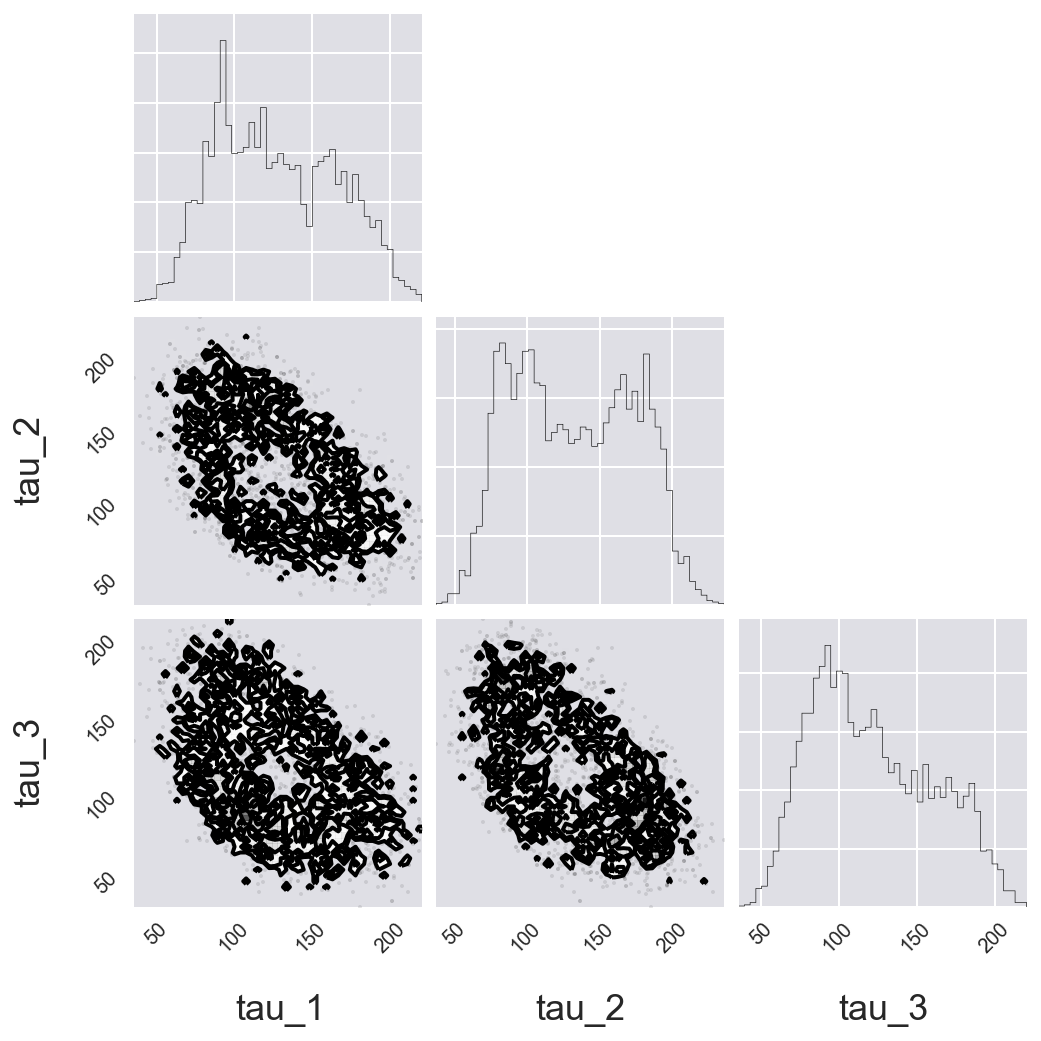

In [11]:
_ = corner.corner(df_out[df_out.beta_ind==0][['tau_1', 'tau_2', 'tau_3']], bins=50)

In [ ]:
df_out.to_csv('./ptmcmc_results_test1.csv')